# Point vortex in potential flow

In [1]:
using Pkg
Pkg.activate("/Users/beckers/Google Drive/Academic/UCLA/CodingInProgress/ViscousFlow.jl");
using ViscousFlow
using Plots
using LinearAlgebra
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Interpolation kernel

In [2]:
function W(u,h)
    v = abs(u)/h
    if 0 ≤ v ≤ 1
        return 1-5*v^2/2+3*v^3/2
    elseif 1 ≤ v ≤ 2
        return 0.5*(2-v)^2*(1-v)
    else
        return 0
    end
end

function dW(u,h)
    v = u/h
    if 0 ≤ abs(v) ≤ 1
        return sign(u)*(-5*abs(v)+9*abs(v)^2/2)
    elseif 1 ≤ abs(v) ≤ 2
        return sign(u)*(-1.5*abs(v)^2+5*abs(v)-4)
    else
        return 0
    end
end

dW (generic function with 1 method)

In [3]:
u = -3:0.1:3
plot(u,M3.(u,1))
plot!(u,dM3.(u,1))

UndefVarError: UndefVarError: M3 not defined

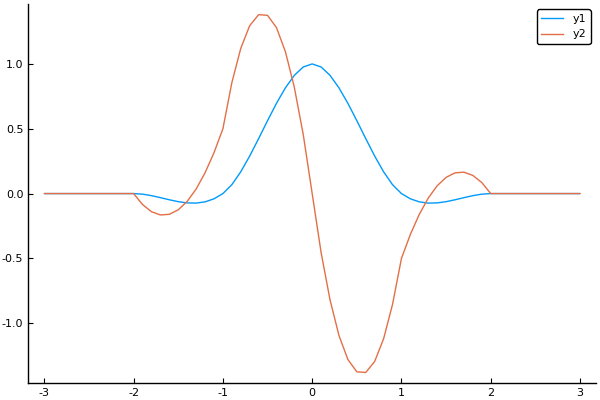

In [4]:
u = -3:0.1:3
plot(u,W.(u,1))
plot!(u,dW.(u,1))

In [5]:
ddf = DDF(ddftype=Fields.M4prime,dx=1)

Discrete delta function operator of type ViscousFlow.Fields.M4prime, with spacing 1.0

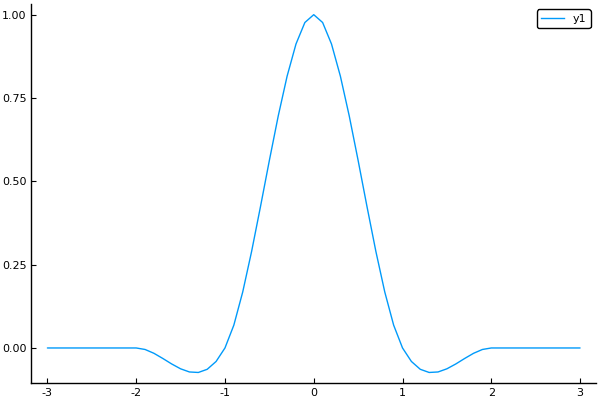

In [6]:
u = -3:0.1:3
plot(u,ddf.(u))

### Eulerian grid

### Regularization/Interpolation

In [7]:
# Regularize from Lagrangian point
Hw = Regularize(Xᵥ,dx;ddftype=Fields.M4prime,issymmetric=true)
# Interpolate from Eulerian grid


UndefVarError: UndefVarError: Xᵥ not defined

In [8]:
nx = 128; ny = 128;
Lx = 2.0;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));
ψ = Nodes(Dual,w);
L = plan_laplacian(size(w),with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 128, ny = 128) grid with spacing 1.0

### Lagrangian points

In [9]:
n = 196

R = 0.5
body = Ellipse(R,R,n)

# Find the minimum arc length
ds = minimum(Bodies.dlength(body))

# Move the circle
xc = 1.0; yc = 1.0
T = RigidTransform((xc,yc),0.0)
T(body)

X = VectorData(body.x,body.y)
f = ScalarData(X);
ψb = ScalarData(X);

# Vortex point
Xv = VectorData([1.0],[1.75])
Γv = ScalarData([1.0]);

### Problem parameters

In [10]:
# The desired streamfunction on the circle surface
ψb .= 1

# The desired circulation about the circle
Γ0 = 0;

### Vorticity

In [11]:
Hv = Regularize(Xv,dx;ddftype=Fields.M4prime,issymmetric=true)
Hv(w,Γv)
# show(IOContext(stdout, :compact => true,:limit => false), "text/plain", w)

Nodes{Dual,128,128} data
Printing in grid orientation (lower left is (1,1))
128×128 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

### Saddle point system

In [12]:
E = Regularize(X,dx;issymmetric=true)
Hmat,Emat = RegularizationMatrix(E,f,w);

In [13]:
L⁻¹(w::T) where {T} = L\w
PS = SaddleSystem((w,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true)

Saddle system with 196 constraints and
   State of type Nodes{Dual,128,128}
   Force of type ScalarData{196}


In [14]:
oB = zeros(size(f))
oB .= 1;

In [15]:
S = Matrix(PS.S);

In [16]:
S₀ = transpose(oB)*(S\oB)
T = S - oB*transpose(oB)/S₀;

TODO: write out formulas

In [17]:
# Note that the first term is actually zero when `ψb` is uniform:
f .= S\(T*(S\(Emat*(L\w).+ψb)) .+ Γ0*oB/S₀);

In [18]:
ψ₀ = -1/S₀*(Γ0 - transpose(oB)*(S\(Emat*(L\w).+ψb)))

1.6136245224147712

In [19]:
ψ .= -(L\(Hmat*f))-(L\(w)) .+ ψ₀; 

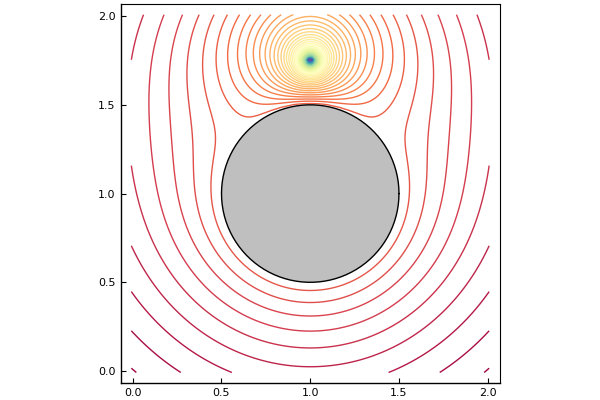

In [20]:
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ,levels=70)
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)